
:::{admonition} Project groups
:class: warning

From next week you will be working on a project in groups of 3-4 students.

It is up to YOU to choose your team members and if possible you should do this during today's workshop.

Submit the names of your team members via the link on Moodle.
:::

# Workshop 5: Image Segmentation

Image segmentation is the process of partitioning a image or video into regions, typically for the purpose of identifying specific objects or features. For example, identifying different tissue types in medical images, or distinguishing objects in astronomical images.
<img src="https://d3i71xaburhd42.cloudfront.net/1b699b098ec7a5e539afd8370d71a82d41e3370d/3-Figure1-1.png" width="400px" />

In this workshop, you will use image segmentation techniques to reproduce part of a famous experiment - Jean Perrin’s confirmation of Einstein’s Brownian motion equation.

In this experiment, tiny particles suspended in water are observed through a microscope. Due to collisions with water molecules, the particles appear to move in a random and erratic fashion known as [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). In 1908 Jean Baptiste Perrin experimentally validated Einstein's kinetic theory of Brownian motion, providing the first direct evidence of the atomic nature of matter and enabling the calculation of an estimate of Avogadro's number.

Our goal is to use image segmentation to track the x- and y- coordinates of one of the particles in the video below.

<iframe width="650" height="395" src="https://mediacentral.ucl.ac.uk/player?autostart=n&videoId=f63a5H5i&captions=y&chapterId=0" frameborder="0" scrolling="no"  allowfullscreen></iframe>

We will perform the following steps to each frame of the video:

1. Read the image data into a numpy array
1. Crop the image so that only one particle is in view
1. Threshold the image to distinguish particle from background
1. Identify the particle x- and y-coordinates using segmentation techniques
1. Store the co-ordinates in an array

The key component of this process is step 3, so we will study this first using a small sample image.

:::{admonition} What you'll learn
:class: hint
1. How to represent image data an array
1. How to extract data from the array using slicing
1. How to use Python libraries to perform image segmentation
:::

## Images: loading and indexing
`bw.png` is an 8x8 pixel image.

<a href="../workshop_5/bw.png" download>bw.png (download link)</a>

![](bw_big.png)

The image contains two particles, and our goal is to identify the larger one and determine its co-ordinates.


An image is essentially a 2-dimensional array where each element represents the colour intensity of each pixel.

First we import the module `matplotlib.image` and use the `imread` function to convert it to an array.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # import the image module

A = mpimg.imread("bw.png") # read the image into an array A
A = np.mean(A, axis=2)

print(np.round(A, 2)) # print x, rounding to 2 d.p.

[[0.27 0.35 0.27 0.37 0.31 0.25 0.29 0.29]
 [0.37 0.46 0.51 0.53 0.45 0.31 0.3  0.28]
 [0.45 0.6  0.75 0.8  0.57 0.43 0.34 0.31]
 [0.46 0.76 0.9  0.89 0.82 0.45 0.32 0.34]
 [0.51 0.79 0.9  0.92 0.75 0.49 0.43 0.29]
 [0.44 0.56 0.75 0.76 0.59 0.56 0.62 0.42]
 [0.36 0.48 0.49 0.47 0.45 0.61 1.   0.56]
 [0.28 0.34 0.31 0.26 0.31 0.4  0.49 0.37]]


> Upload the file `bw.png` and use the above code to read it into an array. (First click the link above to download it to your computer).

The variable `A` stores a numpy array containing the image's pixel data. Lets first investigate a basic property of this array: its shape. Since `shape` is a *property* of a numpy array object, we can access it using dot notation: `A.shape`:

In [18]:
print(A.shape)

(8, 8)


This outputs the size of each dimension of the array, in this case 8 rows and 8 columns. 

In order to access specific elements of the array, we can use *indexing* and bracket (`[...]`) syntax. For example, the following expression gives the first element of the first row of our array: `A[0, 0]`.

In [19]:
print(A[0, 0])

0.26764706


Remember that python starts counting from 0! This means that the first element is at index 0, the second is at index 1 and so on. For a dimension of size 8, the maximum index value is 7. Try using an index value of 8 and see what happens:

In [20]:
print(A[0, 8])

IndexError: index 8 is out of bounds for axis 1 with size 8

We can also access more than one element at a time! To do that we need the colon `:` syntax. On its own, `:` is used to access every element for a given row or column. So the following will give us every element in the 3rd column: `A[:, 2]`

In [21]:
print(A[:, 2])

[0.2735294  0.5088235  0.74705887 0.89705884 0.89705884 0.75
 0.49411765 0.30588236]


Finally, we can use the `:` syntax to access a *range* of values like so: `start_idx:stop_idx`. This is known as slicing. The value at `start_idx` is included but the value at `stop_idx` is excluded. The following will give us the 4th to 7th values of the 2nd row: `A[1, 3:7]`

In [22]:
print(A[1, 3:7])

[0.5323529  0.44705883 0.30882353 0.30294117]


> Use slice indexing to access the following cropped area of the image stored in `A`:

```{image} slice_exercise.png
:width: 200px
```

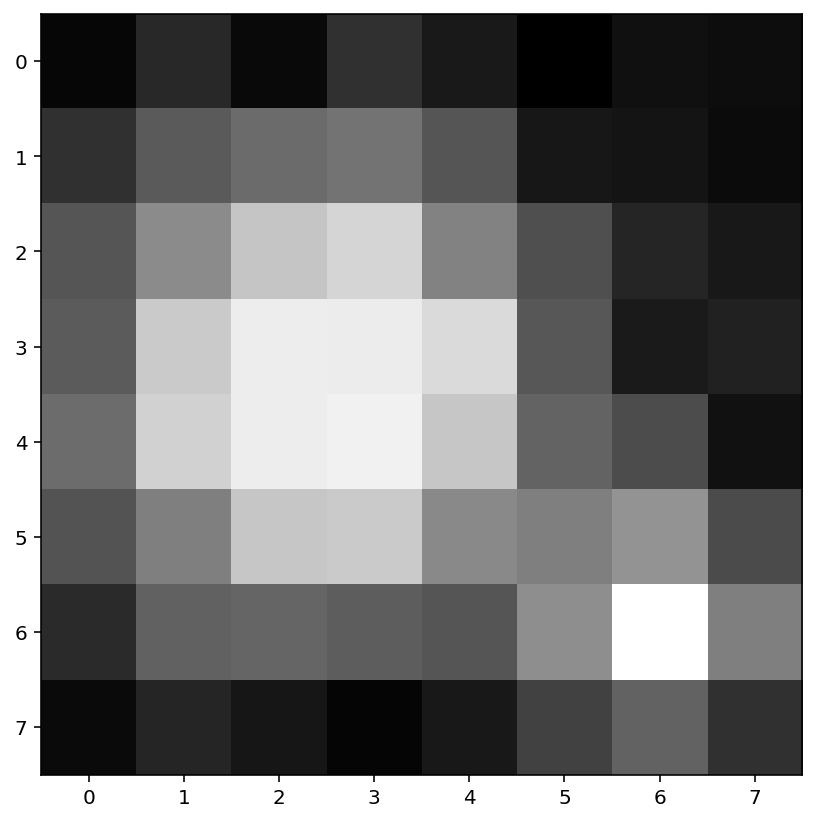

In [23]:
# Adjust these index values to isolate the red box

A_cropped = A[0:8, 0:8]

plt.imshow(A_cropped, 
            cmap=plt.get_cmap('Greys_r') )

# NB This line ensures that the colour scaling remains consistent regardless of cropping
plt.clim(np.amin(A), np.amax(A))

You can learn more about indexing and slicing, including more advanced syntax [here](https://numpy.org/doc/stable/user/basics.indexing.html)

## Thresholding
The next step is to threshold the image, generating an array whose values are 1 for pixels above the threshold, and 0 for pixels below the threshold. The threshold value should of course be between the minimum and maximum values in this array:

In [8]:
print("Min:", np.min(A))
print("Max:", np.max(A))

Min: 0.25
Max: 1.0


Let's choose a threshold value of 0.5. The following code creates an array `A_threshold` whose values are 1 only for pixels above 0.5 and zero everywhere else:

In [9]:
A_threshold = (A > 0.5).astype(int)
print(A_threshold)

[[0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 1 1 1 1 0 0 0]
 [0 1 1 1 1 0 0 0]
 [1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 1 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0]]


Here we used the logical operator `>` "greater than". The expression `A > 0.5` is a logical comparison between the array `A` and the value `0.5`, and returns a new array that is `True` (= 1) where the comparison succeeds and `False` (= 0) where it fails.

> Experiment with different threshold values. Is it possible to isolate just the large (top) blob?

You should have found that you can isolate the smaller (bottom) blob, or two distinct blobs, but it's not possible to find a value which isolates just the larger (top) blob.

Let's use the value 0.7 which results in two disconnected blobs. We'll also display the array `A_threshold` as an image using the function `plt.imshow`:

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 1 1 1 1 0 0 0]
 [0 1 1 1 1 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]]


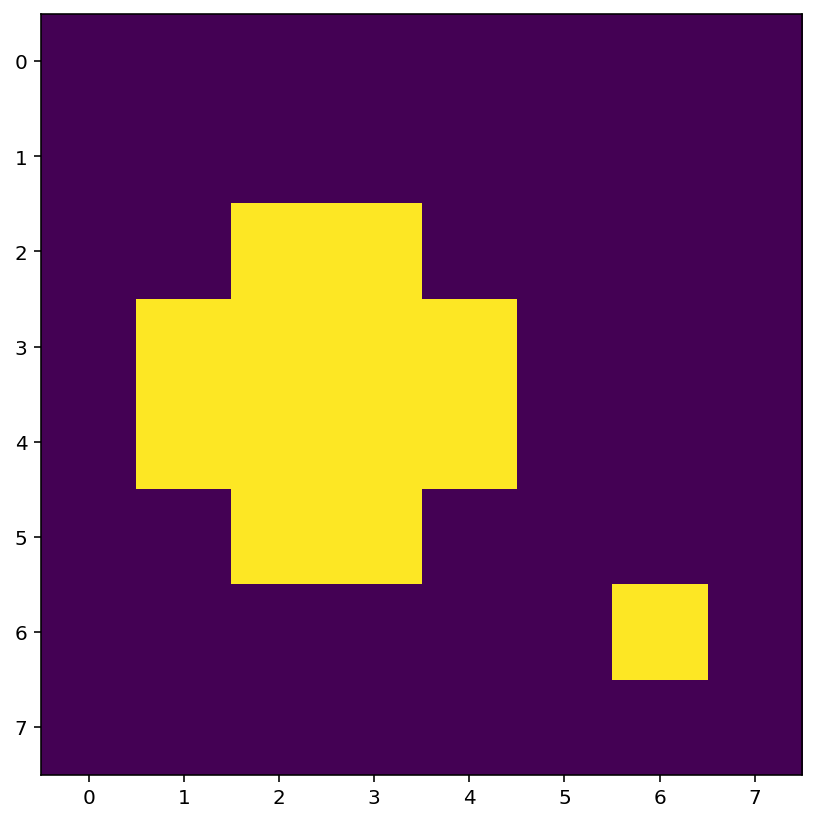

In [11]:
A_threshold = (A > 0.7).astype(int)
print(A_threshold)
plt.imshow(A_threshold)

## Segmentation

The next step is to identify the blobs and determine their size and locations. There is a package called `scipy.ndimage` which contains functions to do exactly this. The following code uses [connected component labelling](https://en.wikipedia.org/wiki/Connected-component_labeling) to identify and print the number of blobs, their sizes and the co-ordinates of the largest one: 

In [12]:
import scipy.ndimage as sn # import the scipy.ndimage package

# Label the connected components (blobs) of binary image A_threshold
A_labels, n = sn.label(A_threshold) 
print("number of blobs:", n)

# Count the number of pixels in each blob and return as array "sizes"
sizes = sn.sum(A_threshold, A_labels, range(1, n+1))
print("sizes:", sizes)

# Get the index of the largest value in sizes (corresponding to the largest blob)
idx = np.argmax(sizes) 
print("index:", idx)

# Determine the co-ordinates of the largest blob (returned as row, column indices)
y_pos, x_pos = sn.center_of_mass(A_threshold, A_labels, idx + 1) 
print("co-ordinates of largest blob:", x_pos, y_pos)

number of blobs: 2
sizes: [12.  1.]
index: 0
co-ordinates of largest blob: 2.5 3.5


We have identified that the largest blob as co-ordinates (2.5, 3.5). Using `plt.scatter` we can mark this location on the image:

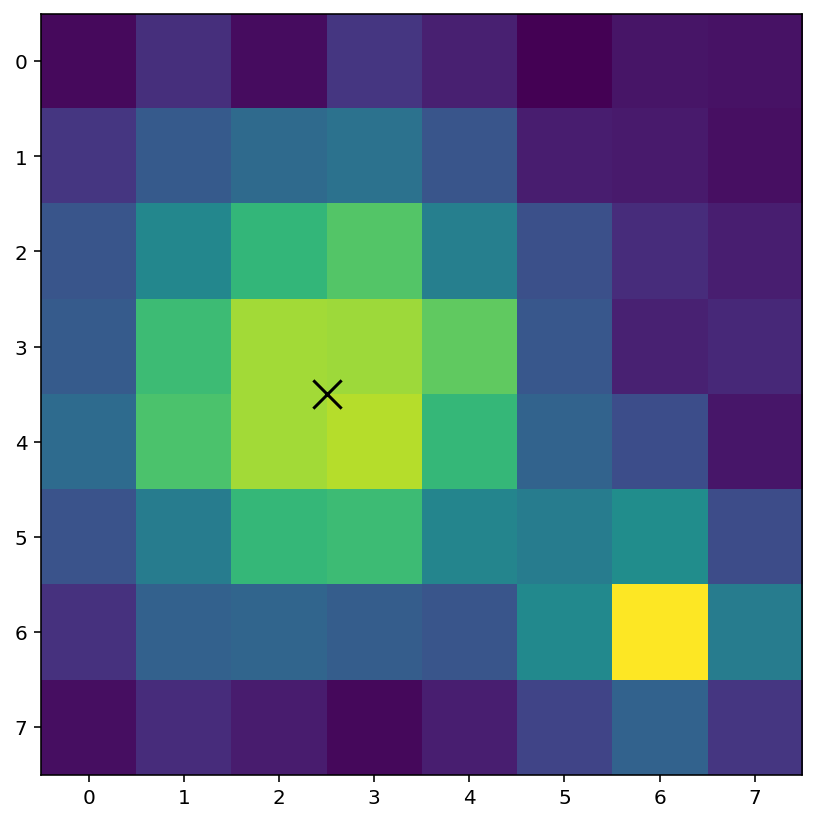

In [13]:
plt.imshow(A) # show the original image
plt.scatter(x_pos, y_pos, color="black", marker="x", s=200)

The image `frame0.png` is part of one frame of the Brownian motion video.

<a href="../workshop_5/frame0.png" download>frame0.png (download link)</a>

> Determine the x- and y-coordinates of the particle in the image `frame0.png`.
> 1. Read the image into an array
> 1. Threshold the image using a suitable threshold value
> 1. Segment the image and determine the location of the largest blob
> 1. Mark the location of the particle on the image

You will need to repeat this sequence of steps during the next section of the workshop. To avoid needless repetition and, maybe more importantly,  typos and errors, we should encapsulate this process in a function. 

> Write a function that takes two inputs: a grayscale image, and a threshold value. Your function should then return the x and y co-ordinates of the largest blob in that image.
> You may use the following template as a starting point:

```
def largest_blob_coords(image, thresh):
    # Threshold the image
    bw = (image > thresh).astype(int)
    # Label the blobs
    labels, n = sn.label(bw)
    
    # Remaining code ...
    
    return x_pos, y_pos
 ```  

> Test your function using the 8x8 image `A` from earlier:

```
A = mpimg.imread("bw.png") 
x, y = largest_blob_coords(A, 0.7)
print(x,y)

# should print 2.5 3.5
```

## Videos

Our goal is to track the location of a moving particle across a sequence of frames of a video. A video is essentially a sequence of frame-by-frame still images, so we can reuse the techniques above. The essential steps are as below:

1. Load the video data into an array
1. Use array slicing to extract a single frame from the array
1. Use slicing to crop the frame so that only one particle is visible
1. Re-use the previous code to identify the particle position

### Load Video Data

The following code loads a video file into an array called `data` and prints out dimensions of each frame and the number of frames. You don't need to understand this code:

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('atomic.avi')

frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.zeros((frameCount, frameHeight, frameWidth, 3), np.dtype('int16'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

data = np.mean(buf[:,:,:,:], axis=-1)

print("Data array dimensions:", data.shape)
print("Number of frames:", data.shape[0])

Data array dimensions: (200, 480, 640)
Number of frames: 200


### Extract First Frame

Our video is stored as a 200x480x640 array, where the first dimension is the time axis and the second two dimensions are the spatial axes. In other words, the video consists of 200 individual 480x640 pixel frames. We can extract the first frame (frame number 0) into an array `f`, using the indexing concepts introduced earlier.

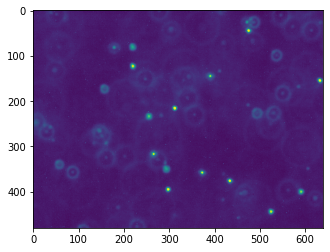

In [15]:
f = data[0,:,:] # extract the first frame

plt.imshow(f)

### Crop the Image

Next we will crop the image to only focus on a single bright particle. We will draw some lines on the image to indicate the cropping boundaries, then use slicing to create an array `f_cropped` containing the cropped image. 


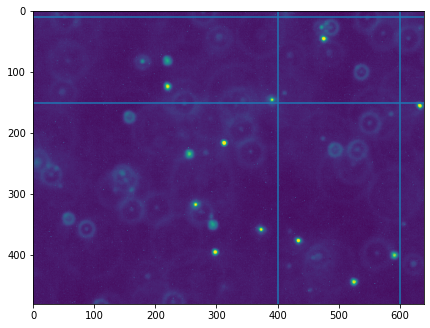

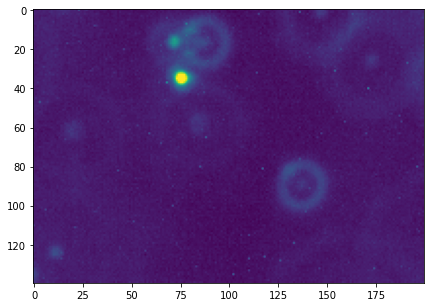

In [16]:
x_min = 400
x_max = 600
y_min = 10
y_max = 150

# Indicate cropping boundaries
plt.figure(figsize=(7,7))
plt.imshow(f)
plt.axvline(x_min)
plt.axvline(x_max)
plt.axhline(y_min)
plt.axhline(y_max)

f_cropped = data[0, y_min:y_max, x_min:x_max]

# Cropped figure
plt.figure(figsize=(7,7))
plt.imshow(f_cropped)

> Use segmentation to determine the x,y-co-ordinates of the particle in the cropped frame. This is a good opportunity to use the function `largest_blob_coords` that you defined previously.

In [25]:
# Threshold value
t = 70

f = data[0, y_min:y_max, x_min:x_max]
plt.figure()
plt.imshow(f)

f_threshold = (f > t).astype(int)
plt.figure()
plt.imshow(f_threshold)

# Add code to determine blob coordinates
# x, y =  ...

NameError: name 'y_min' is not defined

> Repeat for a few other frames in the range 0...10. Can you find a threshold value that works across all frames in this range?

Our final task is to track the random movement of a single particle over time. We already have the tools to isolate a particle and determine its coordinates. All that's left is to store those coordinates for a series of points in time.

To do this, we'll first create arrays to store the coordinates. Then we'll repeat our segmentation process for a sequence of frames, storing the coordinates as we go. 

> Edit the code below to complete the task

In [24]:
num_frames = 20

# Create arrays for storing blob coordinates
x_pos_array = np.zeros(num_frames)
y_pos_array = np.zeros(num_frames)

for i in range(num_frames):
    
    f = data[i, y_min:y_max, x_min:x_max]
    
    # Add code to obtain the x and y coordinates of the largest particle in the current frame here
    # ...
    
    # Store the current coordinates in the corresponding position 
    x_pos_array[i] = x_pos
    y_pos_array[i] = y_pos


NameError: name 'y_min' is not defined

If all goes well, you should have two arrays containing the x and y (or column and row) coordinates as the particle as it moves through time. We can plot those coordinates as a single trajectory:
![](output.png)

> You can recreate the figure above using the following code:

```
plt.figure(figsize=(5,5))
ax = plt.gca()
 
plt.plot(x_pos_array, y_pos_array)
plt.xlim(0, x_max-x_min)
plt.ylim(0, y_max-y_min)

ax.invert_yaxis()
ax.set_aspect('equal')
``` 

### Exercise

Choose another particle in the video and repeat the steps above to track its movement.
